# Imports

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [22]:
import torch
import torch.nn as nn
import torchtext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Union, Optional
from ast import literal_eval
from pathlib import Path

from torchtext.vocab import Vocab
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from datasets import load_metric
from sklearn.model_selection import train_test_split

# Data loading

In [3]:
base_path = Path('..').resolve()
data_path = base_path / Path('data/interim/intermediate.tsv')
model_cktp_path = base_path / 'models' / 'transformer.pt'

tox_data = pd.read_csv(data_path, sep='\t', converters={'reference': literal_eval, 'translation': literal_eval})
tox_data.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"[if, alkar, is, flooding, her, with, psychic, ...","[if, alkar, floods, her, with, her, mental, wa...",0.785171,0.010309,0.014195,0.981983
1,"[now, you, ', re, getting, nasty, .]","[you, ', re, becoming, disgusting, .]",0.749687,0.071429,0.065473,0.999039
2,"[well, ,, we, could, spare, your, life, ,, for...","[well, ,, we, can, spare, your, life, .]",0.919051,0.268293,0.213313,0.985068
3,"[ah, !, monkey, ,, you, ', ve, got, to, snap, ...","[monkey, ,, you, have, to, wake, up, .]",0.664333,0.309524,0.053362,0.994215
4,"[i, ', ve, got, orders, to, put, her, down, .]","[i, have, orders, to, kill, her, .]",0.726639,0.181818,0.009402,0.999348


In [36]:
AMOUNT_OF_PAIRS = 50000
VAL_RATIO = 0.1
MAX_LENGTH = 75
MIN_TOX = 0.75

tox_data = tox_data[
    (tox_data['ref_tox'] >= MIN_TOX) &
    (tox_data['trn_tox'] <= 1 - MIN_TOX) &
    (tox_data['reference'].str.len() <= MAX_LENGTH) &
    (tox_data['translation'].str.len() <= MAX_LENGTH)
]

In [37]:
tox_data['id'] = pd.RangeIndex(0, len(tox_data))
train_split, val_split = train_test_split(
    range(tox_data[tox_data['id'] < AMOUNT_OF_PAIRS]['id'].max() + 1),
    test_size=VAL_RATIO,
    random_state=420
)
train_dataframe = tox_data[tox_data['id'].isin(train_split)]
val_dataframe = tox_data[tox_data['id'].isin(val_split)]

# Dataset

In [38]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
SPECIAL_SYMBOLS = ['<unk>', '<pad>', '<bos>', '<eos>']


class DeToxificationDataset(Dataset):
    def __init__(self,
                 dataframe: pd.DataFrame,
                 vocab: Optional[Vocab] = None):
        self.dataframe = dataframe
        self.reference = self.dataframe['reference'].values
        self.translation = self.dataframe['translation'].values
        self.vocab = vocab or self._create_vocab()

    def _create_vocab(self) -> Vocab:
        new_vocab = torchtext.vocab.build_vocab_from_iterator(
            iter(self.reference + self.translation),
            specials=SPECIAL_SYMBOLS
        )
        new_vocab.set_default_index(UNK_IDX)
        return new_vocab

    def _get_reference(self, index: int) -> list[int]:
        return self.vocab(self.reference[index])

    def _get_translation(self, index: int) -> list[int]:
        # retrieves tags from dataset by index
        return self.vocab(self.translation[index])

    def __getitem__(self, index) -> tuple[list, list]:
        return self._get_reference(index), self._get_translation(index)

    def __len__(self) -> int:
        return len(self.dataframe)

In [39]:
train_dataset = DeToxificationDataset(train_dataframe)
val_dataset = DeToxificationDataset(val_dataframe, vocab=train_dataset.vocab)

In [40]:
def random_sample(some_dataset: DeToxificationDataset, vocab: Vocab):
    idx = np.random.randint(0, len(some_dataset))
    ref, trn = some_dataset[idx]
    print(' '.join(vocab.lookup_tokens(ref)))
    print(' '.join(vocab.lookup_tokens(trn)))


random_sample(train_dataset, train_dataset.vocab)

but , blithe . . the only hope you have is to accept that you ' re already dead .
but , blithe , you have only one hope , and let ' s face it , you ' re already dead .


In [41]:
len(train_dataset), len(val_dataset)

(45000, 5000)

# Dataloaders

In [43]:
def collate_batch(batch: list[np.ndarray]):
    ref_list, trn_list, trn_lengths = [], [], []

    for _ref, _trn in batch:
        ref_list.append(torch.tensor(_ref + [EOS_IDX]))
        trn_list.append(torch.tensor([BOS_IDX] + _trn + [EOS_IDX]))
        trn_lengths.append(len(_trn))

    ref_list = torch.nn.utils.rnn.pad_sequence(ref_list, padding_value=PAD_IDX, batch_first=True)
    trn_list = torch.nn.utils.rnn.pad_sequence(trn_list, padding_value=PAD_IDX, batch_first=True)

    return ref_list, trn_list, trn_lengths


batch_size = 25
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

# Model

In [48]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 dropout: float,
                 max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, embedding_dim, 2) * np.log(10000) / embedding_dim)
        pos = torch.arange(0, max_len).reshape(max_len, 1)

        pos_embedding = torch.zeros((max_len, embedding_dim))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: torch.Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.shape[0], :])

In [49]:
class TransformerDeToxification(nn.Module):
    def __init__(self,
                 num_embeddings: int,
                 embedding_dim: int,
                 nhead: int,
                 num_layers: int,
                 dropout: float):
        super(TransformerDeToxification, self).__init__()
        self.embedding_dim = embedding_dim
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.positional_encoding = PositionalEncoding(embedding_dim, dropout)
        self.transformer = nn.Transformer(
            d_model=embedding_dim,
            nhead=nhead,
            batch_first=True,
            num_decoder_layers=num_layers,
            num_encoder_layers=num_layers,
            dropout=dropout,
        )
        self.linear = nn.Linear(embedding_dim, num_embeddings)

    def forward(self,
                input_s: torch.Tensor,
                target_s: torch.Tensor,
                input_mask: torch.Tensor,
                target_mask: torch.Tensor,
                input_padding_mask: torch.Tensor,
                target_padding_mask: torch.Tensor) -> torch.Tensor:
        input_emb = self.positional_encoding(self.emb(input_s) * np.sqrt(self.embedding_dim))
        target_emb = self.positional_encoding(self.emb(target_s) * np.sqrt(self.embedding_dim))
        outs = self.transformer(
            input_emb,
            target_emb,
            src_mask=input_mask,
            tgt_mask=target_mask,
            src_key_padding_mask=input_padding_mask,
            tgt_key_padding_mask=target_padding_mask,
            memory_key_padding_mask=input_padding_mask,
        )
        return self.linear(outs)

    def encode(self, input_s: torch.Tensor, input_mask: torch.Tensor):
        return self.transformer.encoder(
            self.positional_encoding(self.emb(input_s) * np.sqrt(self.embedding_dim)),
            mask=input_mask
        )

    def decode(self, target: torch.Tensor, memory: torch.Tensor, target_mask: torch.Tensor):
        return self.transformer.decoder(
            self.positional_encoding(self.emb(target) * np.sqrt(self.embedding_dim)),
            memory,
            tgt_mask=target_mask
        )

In [50]:
def generate_square_subsequent_mask(sz: int, dev: torch.device) -> torch.Tensor:
    mask: torch.Tensor = (torch.triu(torch.ones((sz, sz), device=dev)) == 1)
    mask = mask.T
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(input_s: torch.Tensor,
                target_s: torch.Tensor,
                dev: torch.device) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    src_seq_len = input_s.shape[1]
    tgt_seq_len = target_s.shape[1]

    target_mask = generate_square_subsequent_mask(tgt_seq_len, dev)
    input_mask = torch.zeros((src_seq_len, src_seq_len), device=dev).type(torch.bool)

    input_padding_mask = (input_s == PAD_IDX)
    target_padding_mask = (target_s == PAD_IDX)
    return input_mask, target_mask, input_padding_mask, target_padding_mask

# Training

In [51]:
def to_device(dev: torch.device, *args: torch.Tensor) -> tuple[torch.Tensor, ...]:
    return tuple(t.to(dev) for t in args)

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerDeToxification(
    num_embeddings=len(train_dataset.vocab),
    embedding_dim=300,
    nhead=5,
    num_layers=6,
    dropout=0.33,
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
device

device(type='cuda')

In [53]:
# Load the BLUE metric
sacrebleu = load_metric("sacrebleu")
sacrebleu

Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'exp'`. Possible values are:
        - `'none'`: no smoothing
        - `'floor'`: increment zero counts
        - `'add-k'`: increment num/deno

In [62]:
def train(tr_model: nn.Module,
          epochs: int,
          train_ld: DataLoader,
          val_ld: DataLoader,
          optim: torch.optim.Optimizer,
          loss_fn: nn.CrossEntropyLoss,
          vocab: Vocab,
          metric,
          dev: torch.device,
          ckpt_path: Union[Path, str]) -> tuple[list[float], list[float], list[float], float]:
    tr_losses = []
    vl_losses = []
    sacrebleus = []
    _best = 0
    # loop for every epoch (training + evaluation)
    for epoch in range(1, epochs + 1):
        total_loss = 0

        # progress bar
        progress_train = tqdm(enumerate(train_ld, 1), desc="Loss: ", total=len(train_ld))

        # ----------------- TRAINING  --------------------
        # set model to training
        tr_model.train()

        for i, data in progress_train:
            inputs, targets = to_device(dev, *data[:-1])

            # training step for single batch
            optim.zero_grad()

            outputs = tr_model(
                inputs, targets,
                *create_mask(inputs, targets, dev)
            )
            outputs = outputs[:, :-1].permute(0, 2, 1)
            loss = loss_fn(outputs, targets[:, 1:])

            # update running training loss
            current_loss = loss.item()
            total_loss += current_loss

            # optimizer run
            loss.backward()
            optim.step()

            # updating progress bar
            progress_train.set_description("Loss: {:.4f}".format(total_loss / i))

            # releasing unnecessary memory in GPU
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # releasing unnecessary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  -----------------
        # progress bar
        progress_val = tqdm(enumerate(val_ld, 1), desc="Loss: ", total=len(val_ld))
        val_loss_total = 0
        metric_total = 0

        # set model to evaluating (testing)
        tr_model.eval()
        with torch.no_grad():
            for i, data in progress_val:
                lengths = data[-1]
                inputs, targets = to_device(dev, *data[:-1])

                outputs = tr_model(
                    inputs, targets,
                    *create_mask(inputs, targets, dev)
                )
                outputs = outputs[:, :-1].permute(0, 2, 1)

                # update running validation loss
                val_loss_total += loss_function(outputs, targets[:, 1:]).item()
                predicted = outputs.argmax(dim=1)

                predicted = predicted.detach().cpu().numpy()
                targets = targets.detach().cpu().numpy()

                predicted = [' '.join(vocab.lookup_tokens(row[:ln])) for row, ln in zip(predicted, lengths)]
                targets = [[' '.join(vocab.lookup_tokens(row[:ln]))] for row, ln in zip(targets[:, 1:], lengths)]
                metric_total += metric.compute(predictions=predicted, references=targets)['score']

                progress_val.set_description(
                    "Loss: {:.4f}, Sacrebleu: {:.4f}".format(val_loss_total / i, metric_total / i))

                # releasing unnecessary memory in GPU
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        if _best < metric_total / len(val_ld):
            torch.save(tr_model.state_dict(), ckpt_path)
            _best = metric_total / len(val_ld)

        print(
            f"Epoch {epoch}/{epochs}, "
            f"training loss: {total_loss / len(train_ld):.4f}, "
            f"validation loss: {val_loss_total / len(val_ld):.4f}, "
            f"sacrebleu: {metric_total / len(val_ld):.4f}"
        )
        sacrebleus.append(metric_total / len(val_ld))
        tr_losses.append(total_loss / len(train_ld))
        vl_losses.append(val_loss_total / len(val_ld))

    return tr_losses, vl_losses, sacrebleus, _best

In [63]:
train_losses, val_losses, sacrebleus_vals, best_score = train(
    tr_model=model,
    epochs=1,
    train_ld=train_dataloader,
    val_ld=val_dataloader,
    optim=optimizer,
    loss_fn=loss_function,
    vocab=train_dataset.vocab,
    metric=sacrebleu,
    dev=device,
    ckpt_path=model_cktp_path
)

Loss: 3.3280, Sacrebleu: 0.0736: 100%|██████████| 200/200 [00:10<00:00, 18.62it/s]


Epoch 1/1, training loss: 2.9315, validation loss: 3.3280, sacrebleu: 0.0736


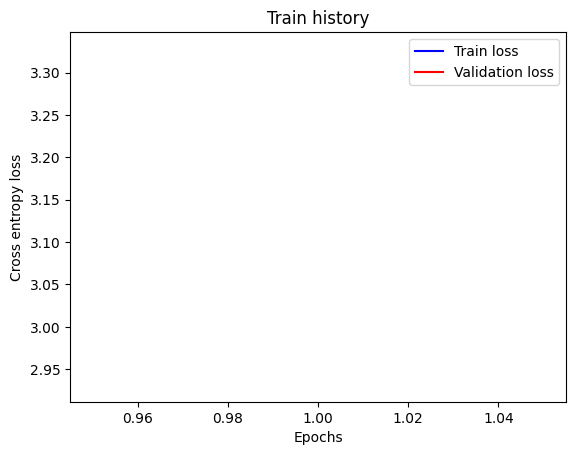

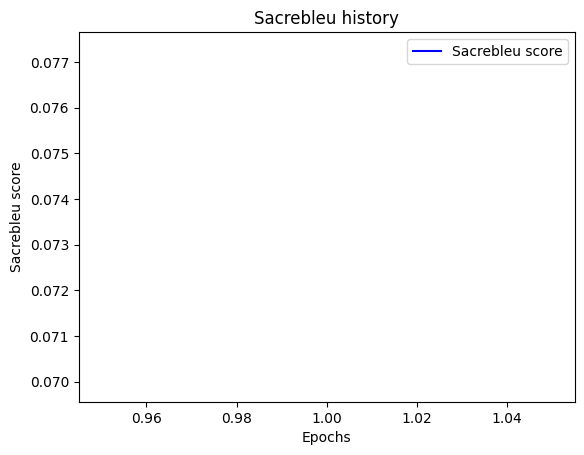

In [64]:
epochs_arr = np.arange(1, len(train_losses) + 1, 1)
plt.title('Train history')
plt.plot(epochs_arr, train_losses, c='b', label='Train loss')
plt.plot(epochs_arr, val_losses, c='r', label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.show()

plt.title('Sacrebleu history')
plt.plot(epochs_arr, sacrebleus_vals, c='b', label='Sacrebleu score')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Sacrebleu score')
plt.show()

# Test

In [66]:
model = TransformerDeToxification(
    num_embeddings=len(train_dataset.vocab),
    embedding_dim=300,
    nhead=5,
    num_layers=6,
    dropout=0.33,
)
model.load_state_dict(torch.load(model_cktp_path))
model.to(device)

TransformerDeToxification(
  (emb): Embedding(30594, 300)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.33, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
          )
          (linear1): Linear(in_features=300, out_features=2048, bias=True)
          (dropout): Dropout(p=0.33, inplace=False)
          (linear2): Linear(in_features=2048, out_features=300, bias=True)
          (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.33, inplace=False)
          (dropout2): Dropout(p=0.33, inplace=False)
        )
      )
      (norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    )
    (de

In [67]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')


def _de_toxification(tr_model: nn.Module, text: str, vocab: Vocab, dev: torch.device, max_length: int = 50) -> str:
    text = text.lower()
    garbage = [
        '^', '&', '*', '%', '@', '#', '$', '_', '+', '-', '=', '>', '<', ':', '~'
    ]
    for symbol in garbage:
        text = text.replace(symbol, '')
    text = text.replace('...', '.')
    tokens = tokenizer(text)

    input_s = torch.tensor(vocab(tokens) + [EOS_IDX]).unsqueeze(0).to(device)
    input_mask = torch.zeros(input_s.shape[1], input_s.shape[1]).type(torch.bool).to(device)

    # Through encoders
    memory = model.encode(input_s, input_mask)

    # Through decoders
    predicted = torch.ones(1, 1).fill_(BOS_IDX).type(torch.long).to(dev)
    for i in range(max_length):
        memory = memory.to(dev)
        target_mask = generate_square_subsequent_mask(predicted.shape[1], dev).type(torch.bool).to(dev)

        out = tr_model.decode(predicted, memory, target_mask)
        probs = model.linear(out[:, -1])
        _, next_word = torch.max(probs, dim=1)
        next_word = next_word.item()

        predicted = torch.cat([predicted, torch.ones(1, 1).type_as(input_s.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break

    # Detach
    predicted = predicted.detach()
    if device.type == 'cuda':
        predicted = predicted.cpu()
    predicted = predicted.numpy()[0, 1:]

    return ' '.join(vocab.lookup_tokens(predicted))


def de_toxification(tr_model: nn.Module, text: str, vocab: Vocab, dev: torch.device, max_length: int = 50) -> str:
    with torch.no_grad():
        return _de_toxification(tr_model, text, vocab, dev, max_length)

In [ ]:
de_tox = de_toxification(model, "You are bastard", train_dataset.vocab, device)
print(de_tox)